In [1]:
import os 
os.getcwd()

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

from scipy.stats import entropy
from scipy.special import rel_entr

from scipy.signal import butter, sosfilt
import random 

pd.set_option('display.max_columns', None)

from my_hms_models import *
from train_hms_models import *

TRAIN_EEG_DIR = Path('./inputs/hms-harmful-brain-activity-classification/train_eegs')
TRAIN_SPECS_DIR = Path('./inputs/hms-harmful-brain-activity-classification/train_spectrograms/')
TRAIN_CSV = Path('./inputs/hms-harmful-brain-activity-classification/train.csv')

PRE_LOADED_SPECTOGRAMS = Path('./inputs/brain-spectrograms/specs.npy')
PRE_LOADED_EEGS = Path('./inputs/brain-eeg-spectrograms/eeg_specs.npy')

BRAIN_ACTIVITY = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

TEST_DYPES ={
    "eeg_label_offset_seconds": "Int64", 
    "spectrogram_label_offset_seconds": "Int64",
    "expert_consensus": "category"
    }

TARGET_PROB = [f"{lb}_prob" for lb in BRAIN_ACTIVITY]

Device: cuda


In [2]:
def cal_entropy(row, apply_cols):
    nc = len(apply_cols)
    uniform_list = [1/nc for i in range(nc)]
    return sum(rel_entr(uniform_list, row[apply_cols].astype('float32').values + 1e-5))

def load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset):

    eeg_df = pd.read_parquet(TRAIN_EEG_DIR/f"{eeg_id}.parquet")
    start_eeg = eeg_offset * 200
    end_eeg = start_eeg + (200 * 50)

    eeg = eeg_df.iloc[start_eeg:end_eeg,]

    spec_df = pd.read_parquet(TRAIN_SPECS_DIR/f"{spec_id}.parquet")
    start_spec = spec_offset
    end_spec = start_spec + 600

    spec = spec_df[(spec_df["time"] <= end_spec) & (spec_df["time"] >= start_spec)]

    return eeg, spec

sos = butter(4, [1, 40], btype="bandpass", fs=200, output='sos')

def central_window_eeg(df, window_seconds=10):
    start = df.index[0]
    end = df.index[-1]
    mid = (start + end) / 2
    new_start = int(mid - window_seconds/2 * 200) - start + 1
    new_end = int(mid + window_seconds/2 * 200) - start + 1
    return df.iloc[new_start:new_end]

def plot_eeg(df, bp_filter=True):

    fig, axs = plt.subplots(20, 1, figsize=(15, 10), sharex=True)
    
    for i, ax in enumerate(axs):
        
        if bp_filter:
            ts_signal = sosfilt(sos, df.iloc[:,i])
        else:
            ts_signal = df.iloc[:,i]

        ax.plot(ts_signal, color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
    
    fig.tight_layout()
    plt.show()

def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

def get_eeg_info(df, row_idx, verbose=True):

    cols = ['eeg_id', 'spectrogram_id', 'patient_id', 'label_id']
    eeg_id, spec_id, patient_id, label_id = df.loc[row_idx, cols]

    eeg_offset = df.loc[row_idx, 'eeg_label_offset_seconds']
    spec_offset = df.loc[row_idx, 'spectrogram_label_offset_seconds']

    print(f"eeg_id: {eeg_id}, spec_id: {spec_id}, patient_id: {patient_id}, label_id: {label_id}")
    print(f"eeg_offset: {eeg_offset} | spec_offset: {spec_offset}")
    print(f"expert_consensus: {df.loc[row_idx, 'expert_consensus']}")
    print(f"entropy: {df.loc[row_idx, 'entropy']:.2f} | Total Votes: {df.loc[row_idx, 'total_votes']}")
    print(f"Votes: ")
    for lb in BRAIN_ACTIVITY:
        vote, prob = f"{lb}_vote", f"{lb}_prob"
        print(f"\t{lb.upper()}: n={df.loc[row_idx, vote]}, p={df.loc[row_idx, prob]:.2f}")

    return eeg_id, spec_id, eeg_offset, spec_offset

In [3]:
train_df = pd.read_csv(TRAIN_CSV, dtype=TEST_DYPES)

targets = train_df.columns[-6:] 
print(targets.tolist())

train_df[TARGET_PROB] = train_df[targets].div(train_df[targets].sum(axis=1), axis=0)

train_df['entropy'] = train_df.apply(lambda x: cal_entropy(x, TARGET_PROB), axis=1)

train_df['total_votes'] = train_df[targets].sum(axis=1)

display(train_df.head(10))

['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,entropy,total_votes
0,1628180742,0,0,353733,0,0,127492639,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
1,1628180742,1,6,353733,1,6,3887563113,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
2,1628180742,2,8,353733,2,8,1142670488,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
3,1628180742,3,18,353733,3,18,2718991173,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
4,1628180742,4,24,353733,4,24,3080632009,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
5,1628180742,5,26,353733,5,26,2413091605,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
6,1628180742,6,30,353733,6,30,364593930,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
7,1628180742,7,36,353733,7,36,3811483573,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
8,1628180742,8,40,353733,8,40,3388718494,42516,Seizure,3,0,0,0,0,0,1.0,0.0,0.000000,0.0,0.000000,0.000000,7.802343,3
9,2277392603,0,0,924234,0,0,1978807404,30539,GPD,0,0,5,0,1,5,0.0,0.0,0.454545,0.0,0.090909,0.454545,4.627146,11


In [43]:
def get_non_overlap(df_csv, targets, group_key=['eeg_id'], calc_method='simple'):
    # Reference Discussion:
    # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

    # train and validate using only 1 crop per eeg_id
    # Simple method: simple average of the votes as probability
    # Weighted method: entropy weighted average of the votes as probability

    tgt_list = targets.tolist()
    brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
    n_classes = len(brain_activity)

    agg_dict = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
        'expert_consensus': 'first',
        'total_votes': 'sum',
        'entropy': 'mean'
    }
    
    groupby = df_csv.groupby(group_key)
    train = groupby.agg(agg_dict)
    train.columns = ['_'.join(col).strip() for col in train.columns.values]
    train.columns = ['spectrogram_id', 'min', 'max', 'patient_id', 'target', 'total_votes', 'entropy']

    if calc_method == 'simple':
        vote_sum = groupby[tgt_list].sum()
        class_probs = vote_sum.div(vote_sum.sum(axis=1), axis=0).reset_index(drop=False)

    elif calc_method == 'weighted':
        weighted_vote_cols = [f"{lb}_weighted" for lb in tgt_list]
        df_csv[weighted_vote_cols] = df_csv[tgt_list].mul(df_csv['entropy'], axis=0)
        vote_sum = df_csv.groupby('eeg_id').apply(
            lambda x: x[weighted_vote_cols].sum(axis=0) / x['entropy'].sum()
            )
        class_probs = vote_sum.div(vote_sum.sum(axis=1), axis=0).reset_index(drop=False)
        class_probs.columns = ['eeg_id'] + tgt_list
        
    train = train.dropna()
    train = train.reset_index(drop=False)
    train = train.merge(class_probs, on=group_key, how='left')
    
    return train

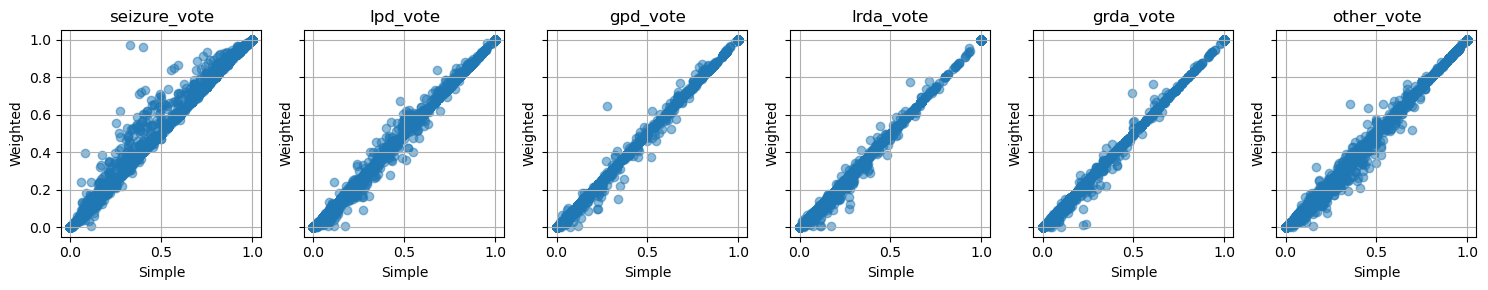

In [44]:
df_simple = get_non_overlap(train_df, targets, calc_method='simple')
df_weighted = get_non_overlap(train_df, targets, calc_method='weighted')

fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(df_simple[BRAIN_ACTIVITY[i]+"_vote"], df_weighted[BRAIN_ACTIVITY[i]+"_vote"], alpha=.5)
    ax.set_title(targets[i])
    ax.grid(True)
    ax.set_xlabel('Simple')
    ax.set_ylabel('Weighted')

fig.tight_layout()
plt.show()

In [45]:
df_simple.head()

,eeg_id,spectrogram_id,min,max,patient_id,target,total_votes,entropy,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0,16,20654,Other,48,4.584192,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0,38,20230,LPD,154,4.870032,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008,1032,5955,Other,2,7.802343,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908,908,38549,GPD,1,7.802343,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0,0,40955,Other,2,7.802343,0.0,0.000000,0.00,0.000000,0.000000,1.000000


In [46]:
df_weighted.head()

,eeg_id,spectrogram_id,min,max,patient_id,target,total_votes,entropy,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0,16,20654,Other,48,4.584192,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0,38,20230,LPD,154,4.870032,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008,1032,5955,Other,2,7.802343,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908,908,38549,GPD,1,7.802343,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0,0,40955,Other,2,7.802343,0.0,0.000000,0.00,0.000000,0.000000,1.000000


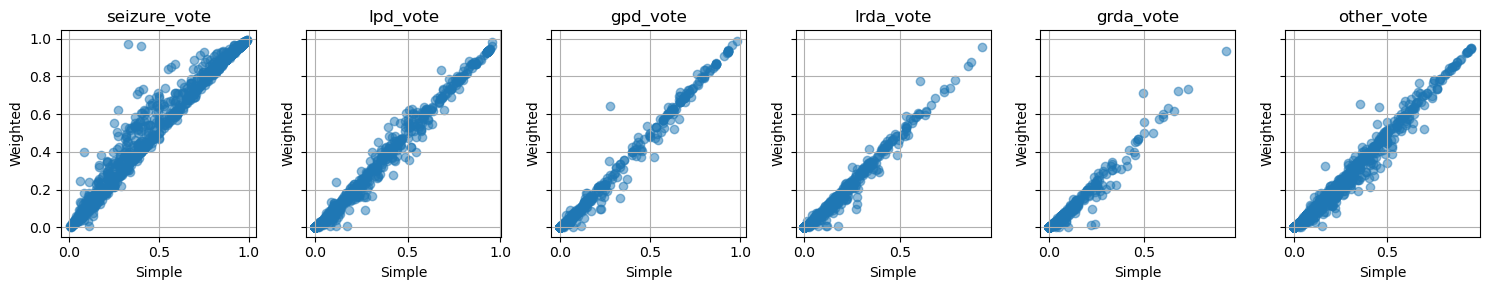

In [47]:
idx = (df_weighted['seizure_vote'] - df_simple['seizure_vote']) != 0

fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(df_simple.loc[idx, targets[i]], df_weighted.loc[idx, targets[i]], alpha=.5)
    ax.set_title(targets[i])
    ax.grid(True)
    ax.set_xlabel('Simple')
    ax.set_ylabel('Weighted')

fig.tight_layout()
plt.show()

In [ ]:
df_high_entropy = train_df[train_df['entropy'] >= 5.5].copy().reset_index(drop=True)
df_low_entropy = train_df[train_df['entropy'] < 5.5].copy().reset_index(drop=True)

print(f"High Entropy: {df_high_entropy.shape[0]}")
print(f"Low Entropy: {df_low_entropy.shape[0]}")

In [ ]:
all_specs = np.load( PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()
all_eegs = np.load( PRE_LOADED_EEGS, allow_pickle=True).item()

In [ ]:
def load_spec_from_parquet(spec_id, spec_offset, all_specs=None):

    prefixes = ['LL', 'RL', 'LP', 'RP']
    spec_array = np.zeros((4, 100, 300))

    if not all_specs:
        spec_df = pd.read_parquet(TRAIN_SPECS_DIR/f"{spec_id}.parquet")
        start_spec = spec_offset
        end_spec = start_spec + 600
        spec_section = spec_df[(spec_df["time"] <= end_spec) & (spec_df["time"] >= start_spec)]
            
        for i, prefix in enumerate(prefixes):
            cols = spec_section.filter(regex=f"^{prefix}_").columns
            _arr = spec_section[cols].values.T
            spec_array[i] = _arr # transform_spectrogram(_arr)

    else:
        r = spec_offset // 2
        for region, prefix in enumerate(prefixes):
            _arr = all_specs[spec_id][r:r+300, region*100:(region+1)*100].T
            spec_array[region] = _arr # transform_spectrogram(_arr)

    return spec_array

def count_invalids(row, all_specs):
    spec_id = row['spectrogram_id']
    spec_offset = row['spectrogram_label_offset_seconds']
    spec_array = load_spec_from_parquet(spec_id, spec_offset, all_specs)
    return np.sum([np.isnan(spec_array[i]).sum() for i in range(4)])

In [ ]:
df_low_entropy['nan_counts'] = df_low_entropy.apply(lambda x: count_invalids(x, all_specs), axis=1)

n = df_low_entropy[df_low_entropy['nan_counts'] > 0].shape[0]
print(f"Low Entropy with NaNs: {n} / {df_low_entropy.shape[0]} [{n/df_low_entropy.shape[0]:.2%}]")

In [ ]:
df_high_entropy['nan_counts'] = df_high_entropy.apply(lambda x: count_invalids(x, all_specs), axis=1)

n = df_high_entropy[df_high_entropy['nan_counts'] > 0].shape[0]
print(f"High Entropy with NaNs: {n} / {df_high_entropy.shape[0]} [{n/df_high_entropy.shape[0]:.2%}]")

In [ ]:
high_entropy_invalids = df_high_entropy[df_high_entropy['nan_counts'] > 0].copy()
low_entropy_invalids = df_low_entropy[df_low_entropy['nan_counts'] > 0].copy()

In [ ]:
rows = low_entropy_invalids.sample(5, random_state=42)

for row_idx in rows.index:
    row = low_entropy_invalids.loc[row_idx]
    spec_id = row['spectrogram_id']
    spec_offset = row['spectrogram_label_offset_seconds']

    spec_arr = load_spec_from_parquet(spec_id, spec_offset, all_specs=all_specs)

    fig, axs = plt.subplots(2, 2, figsize=(13, 6), sharex=True, sharey=True)
    prefixes = ['LL', 'RL', 'LP', 'RP']
    for i, (ax, prefix) in enumerate(zip(axs.flatten(), prefixes)):

        nan_count = np.isnan(spec_arr[i]).sum()
        im = ax.imshow(spec_arr[i, :, :], origin="lower", norm='log', cmap="viridis", interpolation="none")
        # plt.colorbar(im, ax=ax, shrink=0.65)
        ax.set_title(f"{prefix} Invalid Pixels: {nan_count} [{nan_count/(spec_arr[i].size):.2%}]")

    fig.suptitle(f"Total Votes: {row['total_votes']} | Entropy: {row['entropy']:.3f} | {row['expert_consensus']}", fontsize=14, fontweight="bold")
    fig.tight_layout()
    plt.show()

In [ ]:
# Get the non-overlapping data
df_train = get_non_overlap(train_df, targets, 'eeg_id', calc_method='simple')

df_train.shape


In [ ]:
def count_invalids(row, all_specs):
    spec_id = row['spectrogram_id']
    spec_offset = (row['min'] + row['max']) // 2
    spec_array = load_spec_from_parquet(spec_id, spec_offset, all_specs)
    return np.sum([np.isnan(spec_array[i]).sum() for i in range(4)])

In [ ]:
df_train['nan_counts'] = df_train.apply(lambda x: count_invalids(x, all_specs), axis=1)

In [ ]:
print(f"Samples with NaNs: {df_train[df_train['nan_counts'] > 0].shape[0]} / {df_train.shape[0]}")

In [ ]:
samples_with_nans = df_train[df_train['nan_counts'] > 0].copy()

rows = samples_with_nans.sample(5, random_state=42)

for row_idx in rows.index:
    row = samples_with_nans.loc[row_idx]

    spec_id = row['spectrogram_id']
    spec_offset = (row['min'] + row['max']) // 2

    spec_arr = load_spec_from_parquet(spec_id, spec_offset, all_specs=all_specs)

    fig, axs = plt.subplots(2, 2, figsize=(13, 6), sharex=True, sharey=True)
    prefixes = ['LL', 'RL', 'LP', 'RP']
    for i, (ax, prefix) in enumerate(zip(axs.flatten(), prefixes)):

        nan_count = np.isnan(spec_arr[i]).sum()
        im = ax.imshow(spec_arr[i, :, :], origin="lower", norm='log', cmap="viridis", interpolation="none")
        # plt.colorbar(im, ax=ax, shrink=0.65)
        ax.set_title(f"{prefix} Invalid Pixels: {nan_count} [{nan_count/(spec_arr[i].size):.2%}]")

    fig.suptitle(f"Votes: "+', '.join([f'{x:.2f}' for x in row[targets].tolist()]), fontsize=14, fontweight="bold")
    fig.tight_layout()
    plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

counts, bins = np.histogram(train_df["entropy"],)
axes[0].stairs(counts, bins)
axes[0].set_xticks(np.arange(0, 8, 1), minor=True)
axes[0].grid(True)
axes[0].set_xlabel('Entropy')
axes[0].set_ylabel('Count')

thred = 5.5
small_group = train_df[train_df['entropy'] < thred]
lable_counts = small_group['expert_consensus'].value_counts() / small_group.shape[0]
lable_counts.plot(kind='bar', title='Small group', color='blue', grid=True, ax=axes[1])

large_group = train_df[train_df['entropy'] >= thred]
lable_counts = large_group['expert_consensus'].value_counts() / large_group.shape[0]
lable_counts.plot(kind='bar', title='Large group', color='blue', grid=True, ax=axes[2])

print("Small Entropy Group :", small_group.shape)
print("Large Entropy Group:", large_group.shape)

fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(15, 6), sharex='col', sharey='row')

# for each brain activity, plot the histogram of the total_votes in the two groups
for i, lb in enumerate(BRAIN_ACTIVITY):
    small_group[lb + '_vote'].plot(kind='hist', bins=10, title=lb, ax=ax[0, i], grid=True, color='blue', logy=True)
    large_group[lb + '_vote'].plot(kind='hist', bins=10, title=lb, ax=ax[1, i], grid=True, color='blue', logy=True)

    ax[1, i].set_xlabel('Votes')
    ax[1, i].set_title('')
    # minor ticks on for x-axis
    ax[0, i].tick_params(axis='x', which='minor', bottom=True)
    ax[1, i].tick_params(axis='x', which='minor', bottom=True)

ax[0, 0].set_ylabel('Small Entropy (Hard)')
ax[1, 0].set_ylabel('Large Entropy (Easy)')

fig.tight_layout()
plt.show()

Observe: 
* Not so much seizure samples in small entropy group. Probably due to the fact tha seizure is easy to identify? 
* In small entropy group, number of votes for seizure is in general less than 10.

In [ ]:
# plot a few examples of seizure.
seizure_df = train_df[(train_df['expert_consensus'].str.lower() == 'seizure') & (train_df['entropy'] < 5.5)].sort_values('entropy', ascending=False)
seizure_df = seizure_df.reset_index(drop=True)

n_plots = 10
patients = random.choices(seizure_df['patient_id'].unique(), k=n_plots)
patients = list(set(patients))

seizure_sample_idx = [
    random.choice(seizure_df[seizure_df['patient_id'] == patient].index) for patient in patients
    ]

for idx in seizure_sample_idx:
    eeg_id, spec_id, eeg_offset, spec_offset = get_eeg_info(seizure_df, idx, verbose=True)
    eeg, spec = load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset)
    plot_spec(spec)

In [ ]:
from my_hms_models import *
from train_hms_models import *
import os

# define the paths
paths = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths

print(paths.OUTPUT_DIR)


In [ ]:
# Load the data
train_csv = pd.read_csv(paths.TRAIN_CSV)
TARGETS = train_csv.columns[-6:]

# Get the non-overlapping data
df_train = get_non_overlap(train_csv, TARGETS, ModelConfig.GROUP_KEYS, calc_method='simple')

all_specs = np.load(paths.PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()
all_eegs = np.load(paths.PRE_LOADED_EEGS, allow_pickle=True).item()

df_train.head(10)

In [ ]:
 # Create the dataset
dataset = CustomDataset(
    df_train, TARGETS, ModelConfig, all_specs, all_eegs, False, mode='train')

# Create the dataloader
dataloader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=32,
    num_workers=1, 
    pin_memory=True, 
    drop_last=True
)

In [ ]:
for i, (X, y) in enumerate(dataloader):
    print(f"Batch {i} | X: {X.shape} | y: {y.shape}")
    image_list = [X[i] for i in range(X.shape[0])]
    break

In [ ]:
for im in image_list:
    # detect zeros
    zero_count_spec = np.count_nonzero(im[:4, 14:-14, :] == 0)
    zero_count_eeg = np.count_nonzero(im[4:, :, :] == 0)
    print(f"Zero in spectrogram: {zero_count_spec} | EEG: {zero_count_eeg}")

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(image_list[-2][i])
    ax.axis('off')

plt.show()

In [ ]:
import timm 

avail_pretrained_models = timm.list_models(pretrained=True)

In [ ]:
[md for md in avail_pretrained_models if 'mae' in md]